## Scaling benchmarks for Birch clustering


This notebook benchmarks the modification of the scikit-learn's Birch algorithm proposed in [scikit-learn/scikit-learn#880](https://github.com/scikit-learn/scikit-learn/pull/8808). The results can be visualized for,
  * random data
  * structured data (blobs)
  * dense matrix obtained by running bag of words feature extracion on the ERDM dataset, followed by an LSA decomposition.


In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import Birch
from sklearn.metrics import v_measure_score
from sklearn.datasets import make_blobs
from sklearn.externals import joblib
from sklearn.metrics import v_measure_score
from sklearn.preprocessing import normalize
from sklearn.utils import gen_even_slices
from freediscovery.cluster import Birch as BirchFD

import matplotlib.pyplot as plt
%matplotlib notebook

from IPython.display import display

%load_ext memory_profiler

np.random.seed(42)

n_features = 100
dataset = 'lsa'

def _get_cluster_labels(brc, n_samples):
    labels = np.zeros(n_samples, dtype=int)
    cluster_id = 0
    for current_leaf in brc._get_leaves():
        for sc in current_leaf.subclusters_:
            labels[sc.samples_id_] = cluster_id
            cluster_id += 1
    return labels

def _out_of_core_birch(X):
    brc5 = Birch(n_clusters=None, compute_labels=True)
    for sl in gen_even_slices(X.shape[0], 1000):
        brc5.partial_fit(X[sl])
    return brc5

In [10]:
benchmarks = {'scikit-learn ': lambda X: Birch(n_clusters=None, compute_labels=True).fit(X),
              'scikit-learn [out-of-core]': _out_of_core_birch,
              'freediscovery': lambda X: _get_cluster_labels(BirchFD(n_clusters=None, compute_samples_indices=True, compute_labels=False).fit(X), X.shape[0]),
              }


n_samples_arr = [5000, 10000,  15000, 20000 , 50000, 100000, 200000]
res_cpu = []
res_mem = []

for n_samples in n_samples_arr:

    if dataset == 'rand':
        X = np.random.randn(n_samples, n_features) 
    elif dataset == 'blobs':
        X, y = make_blobs(n_samples, n_features=n_features)
    elif dataset == 'lsa':
        X = joblib.load('birch_data/lsi_700k-300dim.pkl')[:n_samples, :n_features]
    else:
        raise ValueError
    normalize(X, copy=False) 
    
    # performance benchmarks
    res_cpu_el = {}
    for key, func in benchmarks.items():
        try:
            t1 = %timeit -o -r1 -q func(X)
            res_cpu_el[key] = t1.average
        except MemoryError:
            pass

    try:
        labels = _get_cluster_labels(BirchFD(n_clusters=None, compute_samples_indices=True, compute_labels=False).fit(X), X.shape[0])
        res_cpu_el['n_subclusters'] = len(np.unique(labels))
    except MemoryError:
        pass
    
    res_cpu.append(res_cpu_el)
   
    # memory benchmarks
    res_mem_el = {}
    for key, func in benchmarks.items():
        try:
            m1 = %memit -o -r1 -q func(X)
            res_mem_el[key] = max(max(m1.mem_usage) - m1.baseline, 0.1) # set some small floor for log scale
        except MemoryError:
            pass
    res_mem.append(res_mem_el)
    
df_cpu = pd.DataFrame(res_cpu, index=n_samples_arr).round(2)
print('# Performance benchmarks')
display(df_cpu)

df_mem = pd.DataFrame(res_mem, index=n_samples_arr).round(2)
print('# Memory benchmarks')
display(df_mem)

# Performance benchmarks


,freediscovery,n_subclusters,scikit-learn,scikit-learn [out-of-core]
5000,0.40,1687,0.42,0.65
10000,0.93,3219,1.09,1.35
15000,1.47,4656,1.85,2.15
20000,1.99,6096,2.72,2.98
50000,5.20,14343,9.70,8.66
100000,10.59,26986,28.65,20.81
200000,22.27,53311,NaN,66.07


# Memory benchmarks


,freediscovery,scikit-learn,scikit-learn [out-of-core]
5000,0.10,7.50,0.10
10000,0.10,245.59,0.10
15000,0.10,555.61,0.10
20000,25.87,960.57,4.46
50000,42.37,5510.09,22.01
100000,110.72,20672.62,37.01
200000,226.70,NaN,201.90


<IPython.core.display.Javascript object>


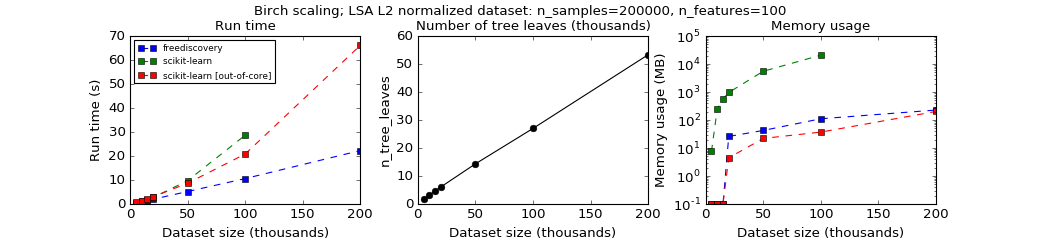

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
fig.subplots_adjust(wspace=0.25, top=0.85, bottom=0.15)

for key in df_cpu.columns:
    if key == 'n_subclusters':
        continue
    ls = 'solid' if 'PR' in key else 'dashed'
    marker = 'o' if 'predict' in key else 's'
    ax[0].plot(df_cpu.index/1000, df_cpu[key], ls=ls, marker=marker, label=key)
    ax[2].semilogy(df_mem.index/1000, df_mem[key], ls=ls, marker=marker)
_ = ax[0].legend(loc='best', prop={'size': 8})

ax[0].set_ylabel('Run time (s)')

ax[1].plot(df_cpu.index/1000, df_cpu.n_subclusters/1000, color='k', marker='o')

ax[1].set_ylabel('n_tree_leaves')

ax[2].set_ylabel('Memory usage (MB)')

ax[0].set_title('Run time', fontsize=12)
ax[1].set_title('Number of tree leaves (thousands)', fontsize=12)
ax[2].set_title('Memory usage', fontsize=12)
for axi in ax:
    axi.set_xlabel('Dataset size (thousands)')

fig.suptitle('Birch scaling; LSA L2 normalized dataset: n_samples={}, n_features={}'.format(X.shape[0], X.shape[1]))